In [24]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-12-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2020-12-31_2_2024-11-24 01_29_40.pt"

GRAPH_TITLE = "EIIE Trained 2009-2020, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3018, 8)


# Portfolio Optimization Algorithm

In [25]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73325447 0.49973674 0.79356218 0.56069532 0.53807884 0.51365253
 0.47050007 0.4535413  0.4616515  0.57103289 0.46439158 0.53378733
 0.61479425 0.58567169 0.80647558 0.50345004 0.72067673 0.72977091
 0.90836283 0.54361322 0.42626132 0.45990717 0.43075238 0.38731389
 0.36481715 0.39284214 0.37376857 0.32891118 0.30775351 0.41229692
 0.50103437 0.4956013  0.44858818 0.53172473 0.80985935 0.56817462
 0.75831475 0.84203104 0.59513019 0.52325379 0.57803172 0.91159258
 0.78680078 0.78992206 0.66276421 0.57279718 0.52717125 0.45082067
 0.47281647 0.58960399 0.57274243 0.62031431 0.94942914 0.57263856
 0.48849092 0.45299737 0.5057736  0.48134831 0.4135398  0.43837034
 0.60544525 0.38421973 0.45361498 0.41022459 0.42708666 0.45460458
 0.54589994 0.46778252 0.466

In [26]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_3548\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=t

<All keys matched successfully>

In [27]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 860887.75
Final accumulative portfolio value: 0.86088775
Maximum DrawDown: -0.33212186735183036
Sharpe ratio: -0.22694975209331217
Total commission cost: 7982.206868955283


In [28]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2021-03-16
1      1.001067e+06 2021-03-17
2      9.784485e+05 2021-03-18
3      9.727900e+05 2021-03-19
4      9.872130e+05 2021-03-22
..              ...        ...
449    8.532707e+05 2022-12-23
450    8.497760e+05 2022-12-27
451    8.404979e+05 2022-12-28
452    8.559408e+05 2022-12-29
453    8.608878e+05 2022-12-30

[454 rows x 2 columns]


In [29]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2021-03-16 00:00:00
2022-12-30 00:00:00


In [30]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [31]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 873785.4375
Final accumulative portfolio value: 0.8737854375
Maximum DrawDown: -0.2908174526499432
Sharpe ratio: -0.21696955351546784
Total commission cost: 4122.475002370309
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2021-03-16
1         1.003868e+06 2021-03-17
2         9.797720e+05 2021-03-18
3         9.706845e+05 2021-03-19
4         9.826881e+05 2021-03-22
..                 ...        ...
449       8.728624e+05 2022-12-23
450       8.695541e+05 2022-12-27
451       8.571482e+05 2022-12-28
452       8.722942e+05 2022-12-29
453       8.737854e+05 2022-12-30

[454 rows x 2 columns]


In [32]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 880296.375
Final accumulative portfolio value: 0.880296375
Maximum DrawDown: -0.27591909556054794
Sharpe ratio: -0.20878062501764372
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2021-03-16
1         1.003868e+06 2021-03-17
2         9.797218e+05 2021-03-18
3         9.706304e+05 2021-03-19
4         9.825176e+05 2021-03-22
..                 ...        ...
449       8.813513e+05 2022-12-23
450       8.778466e+05 2022-12-27
451       8.647828e+05 2022-12-28
452       8.797719e+05 2022-12-29
453       8.802964e+05 2022-12-30

[454 rows x 2 columns]


In [33]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 595963.6875
Final accumulative portfolio value: 0.5959636875
Maximum DrawDown: -0.5920911263131434
Sharpe ratio: -0.6436621913123203
Total commission cost: 312443.67478927807
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2021-03-16
1           1.003868e+06 2021-03-17
2           9.735749e+05 2021-03-18
3           9.726625e+05 2021-03-19
4           9.552106e+05 2021-03-22
..                   ...        ...
449         6.052965e+05 2022-12-23
450         6.018164e+05 2022-12-27
451         5.821834e+05 2022-12-28
452         5.986735e+05 2022-12-29
453         5.959637e+05 2022-12-30

[454 rows x 2 columns]


In [34]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 843380.5
Final accumulative portfolio value: 0.8433805
Maximum DrawDown: -0.3101282945372906
Sharpe ratio: -0.17747887153097905
Total commission cost: 15484.219020715565
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2021-03-16
1         1.003868e+06 2021-03-17
2         9.735749e+05 2021-03-18
3         9.726625e+05 2021-03-19
4         9.552106e+05 2021-03-22
..                 ...        ...
449       8.551577e+05 2022-12-23
450       8.553958e+05 2022-12-27
451       8.404065e+05 2022-12-28
452       8.455217e+05 2022-12-29
453       8.433805e+05 2022-12-30

[454 rows x 2 columns]


In [35]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 549297.0
Final accumulative portfolio value: 0.549297
Maximum DrawDown: -0.5498112734405263
Sharpe ratio: -0.7975587079455757
Total commission cost: 269097.58398835367
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2021-03-16
1         1000000.0000 2021-03-17
2         1000000.0000 2021-03-18
3         1000000.0000 2021-03-19
4         1000000.0000 2021-03-22
..                 ...        ...
449        556046.8125 2022-12-23
450        550820.8750 2022-12-27
451        532851.5000 2022-12-28
452        547944.2500 2022-12-29
453        549297.0000 2022-12-30

[454 rows x 2 columns]


In [36]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (16908, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 7809912.0
Final accumulative portfolio value: 7.809912
Maximum DrawDown: -0.42705969832622426
Sharpe ratio: 0.8256769047110034
Total commission cost: 278773.5828778021
hit end!
               0           1          2           3           4          5
0       6.447411   43.777550  13.519423   23.300673   19.785194  13.113416
1       6.458559   45.211342  13.512955   23.308210   19.558470  12.982839
2       6.355828   46.582809  13.467625   23.165169   19.295834  12.953818
3       6.344078   48.468555  13.338132   22.924255   19.475418  12.961072
4       6.386254   48.001022  13.487050   23.082357   19.529287  12.895784
...          ...         ...        ...         ...         ...        ...
2813  118.585388  230.610001  56.999153  226.496429  214.354141  40.614822
2814  117.498375  245.339996  56.617168  225.178818  217.087555  41.651546
2815  119.437401  252.000000  57.581253  229.742065  219.986328  41.635796
2816  118.526642  

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1040589.8125
Final accumulative portfolio value: 1.0405898125
Maximum DrawDown: -0.2645305599135359
Sharpe ratio: 0.21430641478454932
Total commission cost: 2414.2548780188663
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2021-03-16
1          9.951209e+05 2021-03-17
2          9.649938e+05 2021-03-18
3          9.642011e+05 2021-03-19
4          9.872404e+05 2021-03-22
..                  ...        ...
449        1.055858e+06 2022-12-23
450        1.045266e+06 2022-12-27
451        1.016988e+06 2022-12-28
452        1.039451e+06 2022-12-29
453        1.040590e+06 2022-12-30

[454 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [37]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1099518.375
Final accumulative portfolio value: 1.099518375
Maximum DrawDown: -0.24374559977662325
Sharpe ratio: 0.3602622725374933
Total commission cost: 2543.489989043097
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2021-03-16
1          9.921044e+05 2021-03-17
2          9.744427e+05 2021-03-18
3          9.834574e+05 2021-03-19
4          9.934259e+05 2021-03-22
..                  ...        ...
449        1.115029e+06 2022-12-23
450        1.111745e+06 2022-12-27
451        1.088928e+06 2022-12-28
452        1.101062e+06 2022-12-29
453        1.099518e+06 2022-12-30

[454 rows x 2 columns]


# Stock environment optimization algorithm

In [38]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (453, 8)
Annual return          0.006674
Cumulative returns     0.012029
Annual volatility      0.167793
Sharpe ratio           0.123543
Calmar ratio           0.030417
Stability              0.298355
Max drawdown          -0.219408
Omega ratio            1.021153
Sortino ratio          0.173110
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.996726
Daily value at risk   -0.021058
dtype: float64
df_dji:            date           dji
0   2021-03-16  1.000000e+06
1   2021-03-17  1.005770e+06
2   2021-03-18  1.001107e+06
3   2021-03-19  9.939688e+05
4   2021-03-22  9.971136e+05
..         ...           ...
449 2022-12-23  1.011515e+06
450 2022-12-27  1.012661e+06
451 2022-12-28  1.001516e+06
452 2022-12-29  1.012029e+06
453 2022-12-30           NaN

[454 rows x 2 columns]
df_dji:                       dji
date                    
2021-03-16  1.000000e+06
2021-03-17  1.005770e+06
2021-03-18  1.001107e+06
2021-03-19  9.939688e+05

# Compare all results

In [39]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2021-03-16  1.000000e+06
2021-03-17  1.005770e+06
2021-03-18  1.001107e+06
2021-03-19  9.939688e+05
2021-03-22  9.971136e+05
...                  ...
2022-12-23  1.011515e+06
2022-12-27  1.012661e+06
2022-12-28  1.001516e+06
2022-12-29  1.012029e+06
2022-12-30           NaN

[454 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2021-03-16        1.000000e+06       1.000000e+06   
1         1.003868e+06 2021-03-17        9.921044e+05       1.003868e+06   
2         9.797720e+05 2021-03-18        9.744427e+05       9.797218e+05   
3         9.706845e+05 2021-03-19        9.834574e+05       9.706304e+05   
4         9.826881e+05 2021-03-22        9.934259e+05       9.825176e+05   
..                 ...        ...                 ...                ...   
449       8.728624e+05 2022-12-23        1.115029e+06       8.813513e+05   
450       8.695541e+05 2022-12-27        1.

# Baseline CRP in the environment

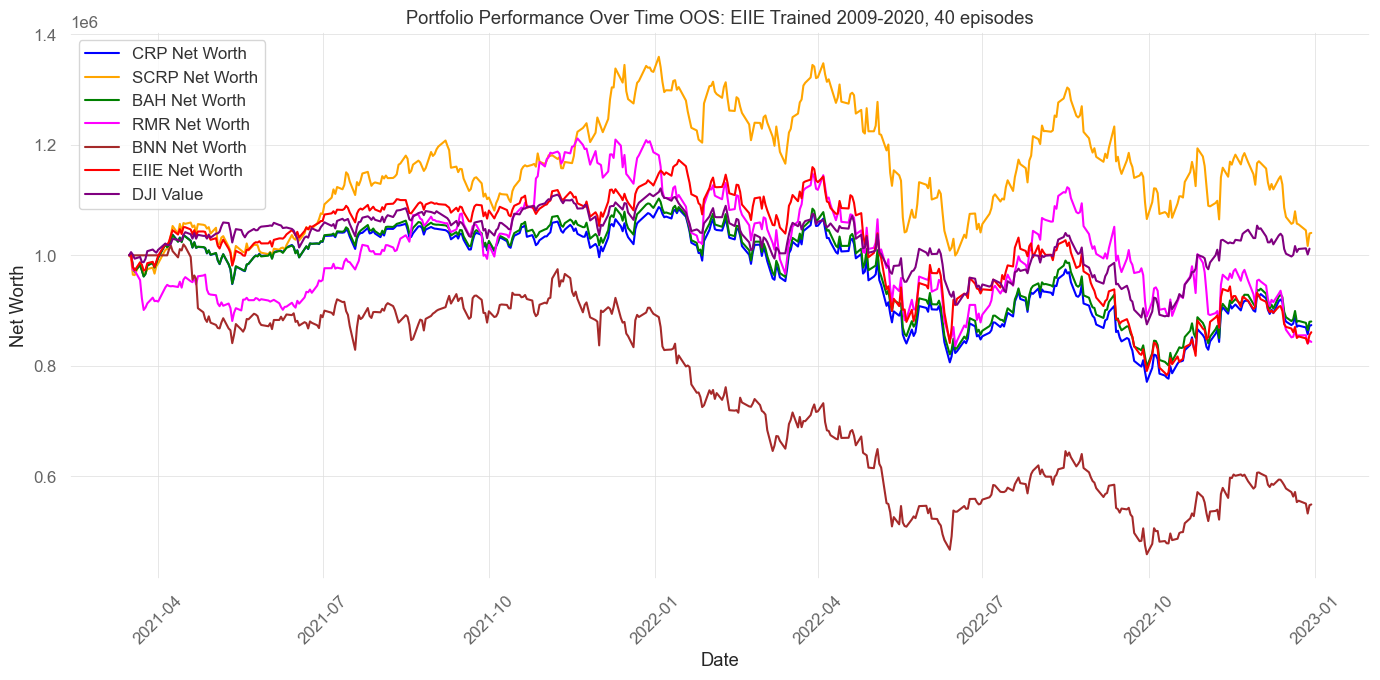

In [40]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 880296.375,
 'BCRP OPT': 1099518.375,
 'BNN': 549297.0,
 'CRP': 873785.4375,
 'EIIE': 860887.75,
 'OLMAR': 595963.6875,
 'RMR': 843380.5,
 'SCRP': 1040589.8125}


In [42]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': -0.29917678694304073,
 'BCRP': 0.2630327266443593,
 'BNN': -0.856672169490657,
 'CRP': -0.3052972336708737,
 'EIIE': -0.3104549173956929,
 'OLMAR': -0.7013264403415236,
 'RMR': -0.24597500549418225,
 'SCRP': 0.1371854666233922}


In [43]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.27591909556054794,
 'BCRP': -0.24374559977662325,
 'BNN': -0.5498112734405263,
 'CRP': -0.2908174526499432,
 'EIIE': -0.33212186735183036,
 'OLMAR': -0.5920911263131434,
 'RMR': -0.3101282945372906,
 'SCRP': -0.2645305599135359}


In [44]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.49448123620309054,
 'BCRP': 0.5364238410596026,
 'BNN': 0.4503311258278146,
 'CRP': 0.4900662251655629,
 'EIIE': 0.48123620309050774,
 'OLMAR': 0.45916114790286977,
 'RMR': 0.4878587196467991,
 'SCRP': 0.5033112582781457}


In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq     df         F    PR(>F)
Portfolio  2.408687e-07    1.0  0.001136  0.973125
Residual   1.917535e-01  904.0       NaN       NaN


In [46]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.003868
2     -0.024053
3     -0.009279
4      0.012247
5     -0.010159
         ...   
449    0.001929
450   -0.003977
451   -0.014882
452    0.017333
453    0.000596
Name: BAH_opt_daily_return, Length: 453, dtype: float64
t-statistic: -0.03369789123274481
p-value: 0.9731254993304252
